# Jessica's Charts

In [1]:
# !pip install altair_saver --quiet

## Loading dependencies/libraries

In [2]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe
from altair_saver import save

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Load & Wrangle Data

In [3]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency_K_pop_numeric,Frequency_Latin_numeric,Frequency_Lofi_numeric,Frequency_Metal_numeric,Frequency_Pop_numeric,Frequency_R&B_numeric,Frequency_Rap_numeric,Frequency_Rock_numeric,Frequency_Video_game_music_numeric,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,3,3,1,0,3,2,3,0,2,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,1,2,1,0,2,2,1,3,1,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,3,0,2,2,1,0,1,1,3,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,2,3,2,0,2,2,0,0,0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,3,2,2,0,2,3,3,0,1,10


In [4]:
mxmh_scores = mxmh.melt(id_vars=["Timestamp", "Age", "Music effects"], 
                     value_vars=["Anxiety", "Depression", "Insomnia", "OCD"], 
                     var_name="Mental Health Condition", 
                     value_name="Self-report Score")

domain_list_ordered = ['Improve', 'No effect', 'Worsen', 'No response']

mxmh_scores["Music effects"] = pd.Categorical(mxmh_scores["Music effects"], 
                                              categories=domain_list_ordered, 
                                              ordered=True)

mxmh_scores

,Timestamp,Age,Music effects,Mental Health Condition,Self-report Score
0,2022-08-27 19:29:02,18.0,No response,Anxiety,3.0
1,2022-08-27 19:57:31,63.0,No response,Anxiety,7.0
2,2022-08-27 21:28:18,18.0,No effect,Anxiety,7.0
3,2022-08-27 21:40:40,61.0,Improve,Anxiety,9.0
4,2022-08-27 21:54:47,18.0,Improve,Anxiety,7.0
...,...,...,...,...,...
2911,2022-10-30 14:37:28,17.0,Improve,OCD,9.0
2912,2022-11-01 22:26:42,18.0,Improve,OCD,5.0
2913,2022-11-03 23:24:38,19.0,Improve,OCD,2.0
2914,2022-11-04 17:31:47,19.0,Improve,OCD,1.0


## Aesthetic Settings

In [5]:
# === COLOR PALETTE ===
okabe_ito_palette = [
    "#009E73",  # Green
    "#0072B2",  # Blue
    "#56B4E9",  # Sky Blue
    "#F0E442",  # Yellow
    "#E69F00",  # Orange
    "#D55E00",  # Vermillion
    "#CC79A7",  # Pink
    '#23338A',  # Dark Blue [colour blind safe addition]
]

In [6]:
# === FONT SETTING ===
font_choice = "Segoe UI"

legend_configuration = {"titleFontSize": 15,
    "labelFontSize": 15,
    "fillColor": '#F5F5F5',
    "padding": 10,
    "cornerRadius": 10,
    "labelFont": font_choice,
    "labelSeparation": 5,
    "titleFont": font_choice,
    "titleLimit": 240
}

title_configuration = {
    "fontSize": 25,
    "anchor": "middle", 
    "font": font_choice,
    "subtitlePadding": 10,
    "subtitleFont": font_choice,
    "subtitleColor": "#525252",
    "subtitleFontSize": 17
}

axis_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 18
}

header_configuration = {
    "labelFont": font_choice,
    "titleFont": font_choice,
    "labelFontSize": 15,
    "titleFontSize": 18
}

## Question 1: What is the distribution of self-reported mental health scores based on opinions of music on mental health?

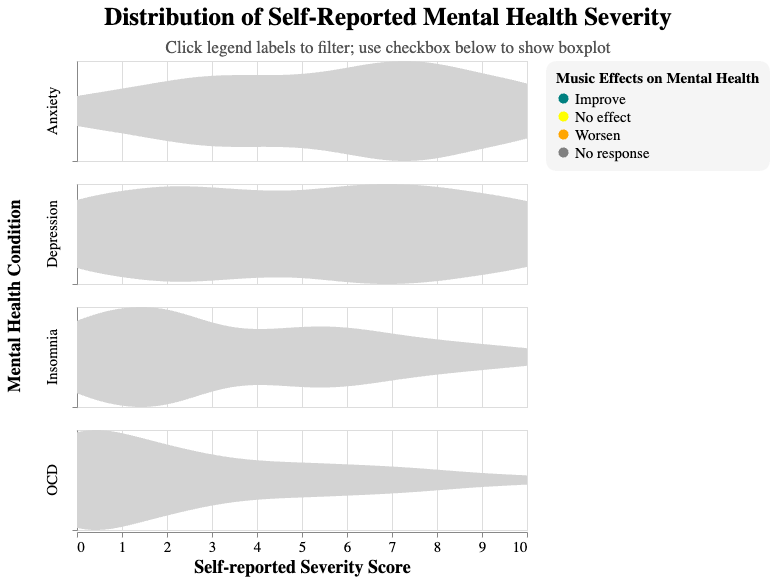

In [19]:
### UI widget ###
selection = alt.selection_point(fields=['Music effects'], bind='legend', empty=False)

bind_checkbox = alt.binding_checkbox(name='Show Boxplot: ')
param_checkbox = alt.param(bind=bind_checkbox)

### Color and Order for Music Effects ###
four_colors = ["teal", "yellow", "orange", "grey"]
color_scale = alt.Scale(domain=domain_list_ordered, range=four_colors)

### Box-plot ###
boxplot = alt.Chart().mark_boxplot(color='black', opacity=0.4, size=30).encode(
	alt.X('Self-report Score:Q', title="Self-reported Severity Score"),
    opacity=alt.when(param_checkbox).then(alt.value(0.75)).otherwise(alt.value(0)),
).add_params(
    param_checkbox
).properties(
    width=450
)

### Violin-plot ###
violin = alt.Chart().transform_density(
	'Self-report Score',
	as_=['Self-report Score', 'density'],
	extent=[0, 10],
	groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical', interpolate='monotone').encode(
	x=alt.X('Self-report Score:Q', title="Self-reported Severity Score"),
	y=alt.Y('density:Q',
            stack='center',
            impute=None,
            title=None,
            scale=alt.Scale(nice=False, zero=True),
            axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)),
    color=alt.condition(selection, 
                        alt.Color("Music effects:N", title="Music Effects on Mental Health", scale=color_scale), 
                        alt.value("lightgrey"))
).properties(width=450, height=100
).add_params(selection
)

### Combined Chart ###
chart1 = alt.layer(
    violin,
    boxplot,
    data=mxmh_scores
).facet(row=alt.Row('Mental Health Condition:N')
).resolve_scale(y=alt.ResolveMode("independent")
).properties(
    title=alt.Title("Distribution of Self-Reported Mental Health Severity",
                    subtitle="Click legend labels to filter; use checkbox below to show boxplot"
                   )
).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
).configure_header(
    **header_configuration
)

chart1.show()
# save(chart1, "outputs/chart1.json")



---




**Summary of tasks:**

This visualization was designed to get an overview of the **distribution** of the self-reported mental health scores, split by a self-reported score of whether music `Improves`, has `No effect`, or `Worsens` mental health (or they did not respond). Summarize the tasks it was designed to address and how/whether the visualizations you chose accomplish (or not accomplish) that task.


# Question 2: What are the response patterns for self-reported mental health?

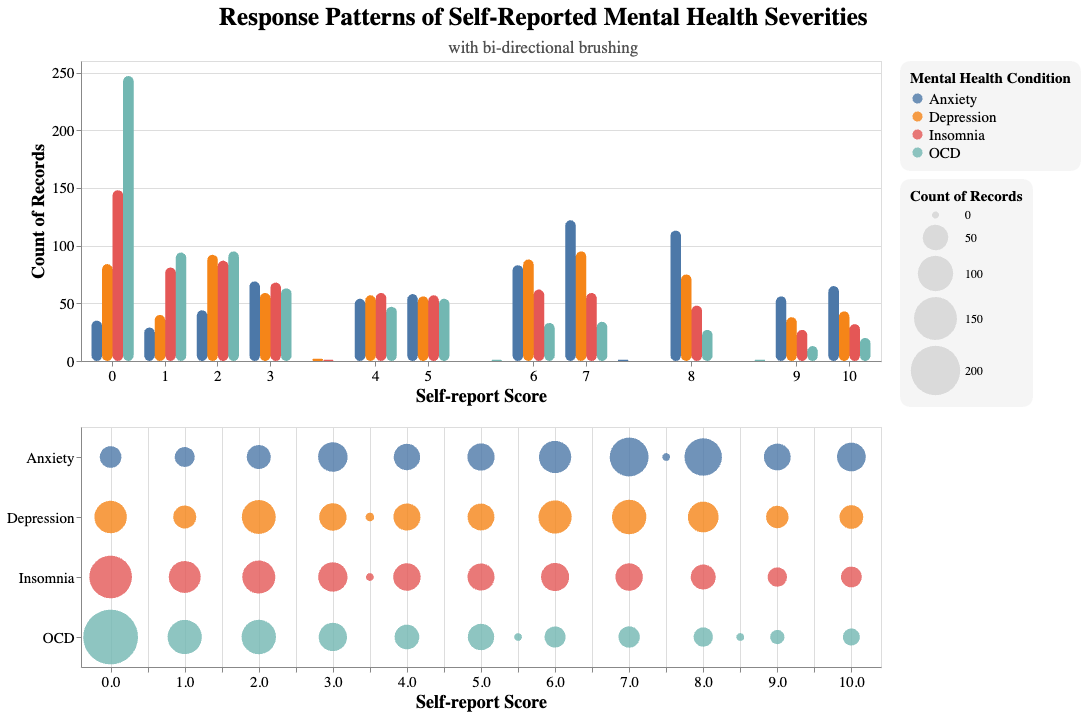

In [8]:
### Interactions ###
brush = alt.selection_interval()
selection = alt.selection_point(fields=['Mental Health Condition'], bind='legend')


### Create a multi-bar plot ###
multibar_b = alt.Chart(mxmh_scores).add_params(
    brush
).mark_bar(cornerRadius=7).encode(
    x=alt.X('Self-report Score:O').axis(labelAngle=0, tickMinStep=0.5, values=list(range(0, 11, 1))),
    xOffset="Mental Health Condition:N",
    y='count():Q',
    color=alt.when(brush).then(alt.Color("Mental Health Condition:N")).otherwise(alt.value("lightgray")),
    tooltip=["Mental Health Condition", 'Self-report Score:O', "count()"]
).properties(width=800, height=300)

### Create a box-plot ###
dotplot_b = alt.Chart(mxmh_scores).add_params(
    brush
).mark_circle(opacity=0.8).encode(
    x=alt.X('Self-report Score', title="Self-report Score", scale=alt.Scale(domain=[-0.4, 10.4])).axis(labelExpr="datum.value % 1 ? null : datum.label"),
    y=alt.Y('Mental Health Condition:N', title=""),
    color=alt.when(brush).then("Mental Health Condition:N").otherwise(alt.value("lightgray")),
    size = alt.Size("count():Q", scale=alt.Scale(rangeMin=50, rangeMax=3000), legend=alt.Legend(labelFontSize=12)),
    tooltip=["Mental Health Condition", "Self-report Score", "count()"]
).properties(width=800, height=240)

chart2 = alt.vconcat(multibar_b, dotplot_b
).properties(
    title=alt.Title("Response Patterns of Self-Reported Mental Health Severities",
                    subtitle="with bi-directional brushing"
                   )
).resolve_axis(x='shared').configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
)

chart2.show()

# save(chart2, "outputs/chart2.json")

- For the visualization below, select the **Mental Health Condition** to look at a condition of interest.
- Use `shift` + click to select multiple categories.

For the visualization below, drag your cursor across the screen to highlight sections of the histogram and dot-chart.

# Question 3: Can we group individuals into clusters based on their music preferences and mental health scores?

In [9]:
# mxmh.head()

## 3.1

In [10]:
dropdown_y = alt.binding_select(
    options=["Age", "BPM"],
    name='Y-axis column '
)

# dropdown for Y column
ycol_param = alt.param(
    value='Age',
    bind=dropdown_y
)

click = alt.selection_point(empty=False)
hover = alt.selection_point(on='mouseover', empty=False)
brush = alt.selection_interval()

# y_axis_selection = alt.binding_select(options=['Age', 'BPM'], name='Y-axis column: ')
# y_axis_variable = alt.param(bind=y_axis_selection, value='Age')

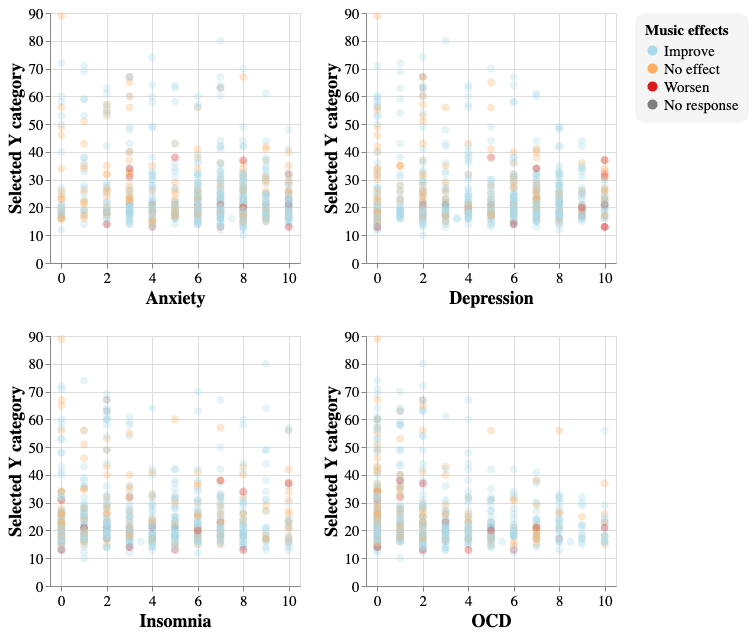

In [11]:
chart3e = alt.Chart(mxmh).mark_circle(opacity=0.75).encode(
    x=alt.X(scale=alt.Scale(domain=[-0.5, 10.5])),
    y=alt.Y('y:Q', title="Selected Y category"),
    color=alt.when(brush).then(alt.Color("Music effects:N", scale=color_scale)).otherwise(alt.value("lightgray")),
    tooltip=alt.Tooltip(['Age', 'Anxiety', 'Depression', 'Insomnia', 'OCD', "Music effects"]),
    size=alt.when(hover).then(alt.value(800)),
    opacity=alt.when(click).then(alt.value(1)).otherwise(alt.value(0.3)),
).properties(
    width=250,
    height=250
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
).add_params(
    hover, brush, ycol_param, click
)

chart3e_anx = chart3e.encode(
    x=alt.X('Anxiety:Q', scale=alt.Scale(domain=[-0.5, 10.5])),
)

chart3e_dep = chart3e.encode(
    x=alt.X('Depression:Q', scale=alt.Scale(domain=[-0.5, 10.5]))
)

chart3e_ins = chart3e.encode(
    x=alt.X('Insomnia:Q', scale=alt.Scale(domain=[-0.5, 10.5]))
)

chart3e_ocd = chart3e.encode(
    x=alt.X('OCD:Q', scale=alt.Scale(domain=[-0.5, 10.5]))
)

chart3_all = ((chart3e_anx | chart3e_dep) & (chart3e_ins | chart3e_ocd)).configure_legend(
    **legend_configuration
).configure_title(
    **title_configuration
).configure_axis(
    **axis_configuration
)


chart3_all.show()

# save(chart3e_all, "outputs/chart3ii.json")

## 3.2

In [12]:
dropdown_x = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='X-axis column '
)

dropdown_y = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='Y-axis column '
)

dropdown_legend = alt.binding_select(
    options=["Primary streaming service",
                    "While working",
                    "Instrumentalist",
                    "Composer",
                    "Exploratory",
                    "Foreign languages",
                   ],
    labels=["Primary streaming service",
                    "Plays music while working",
                    "Plays an instrument",
                    "Composes music",
                    "Explores new music",
                    "Listens to music in foreign languages",
                   ],
    name='Legend: ',
)

# dropdown for X column
xcol_param = alt.param(
    value='Anxiety',
    bind=dropdown_x
)

# dropdown for Y column
ycol_param = alt.param(
    value='Depression',
    bind=dropdown_y
)

# dropdown for legend
legend_param = alt.param(
    value="",
    bind=dropdown_legend,
)

# Chart
chart3b = alt.Chart(mxmh).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title('Selected X Category'),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title('Selected Y Category'),
    color=alt.Color('color:N').title('Legend'),
    size=alt.Size("count()", scale=alt.Scale(domain=[1, 20], rangeMin=50, rangeMax=1000)),
    tooltip=["count()", "median(Anxiety)", "median(Depression)", "median(Insomnia)", "median(OCD)"]
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
    x=f'datum[{xcol_param.name}]',
    color=f'datum[{legend_param.name}]'
).add_params(
    ycol_param,
    xcol_param,
    legend_param
).properties(title=alt.Title("Comparing Mental Health Scores", 
                             subtitle="by Category of Choice", fontSize=20), 
             width=500, 
             height=500)

# chart3b

# save(chart3b, "outputs/chart3i.json")